<a href="https://colab.research.google.com/github/marcospiau/ia368-dd-dl4ir/blob/main/aula02/aula03-finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's in here

Model classifier fine-tuning. 

To reduce total amount of code and also to learn new tools, we're going to use Hugging Face tools (datasets, Trainer etc.) whenever possible.

Also, all data fits in memory, so we will not take too much care on not loading all data in memory at once.

In [ ]:
!nvidia-smi

Wed Mar 15 16:23:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q transformers toolz datasets ftfy neptune-client polars sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.2 MB/s eta 0:00

# Reranker finetuning

## Preprocessing data

### Loading raw data

In [ ]:
import toolz
import transformers
import torch
import datasets
import pandas as pd
import toolz
import fileinput
import os
import itertools
import functools
import more_itertools
import random
from collections import Counter
import ftfy
import multiprocessing as mp
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
TSV_URL = 'https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv'
# !wget -nc {TSV_URL}
# !ls -lht

In [ ]:
%%time
def load_tsv(path):
    # load tsv
    df = (
        pl.read_csv(path, has_header=False,
                    new_columns=['query', 'pos_doc', 'neg_doc'], sep='\t'))
    # fix text encoding
    df = df.select(pl.all().apply(ftfy.fix_text))
    # melt dataframe and process labels (peguei ideia da Mirelle)
    df = df.melt(id_vars='query', value_name='document', variable_name='label')
    df = df.with_columns(pl.col('label').map_dict({'pos_doc': 1, 'neg_doc': 0}))
    # sorting to ensure reproducibility
    df = df.sort('query', 'label', 'document')
    df = df.select('query', 'document', 'label')
    return df

df_tsv = load_tsv(TSV_URL)

CPU times: user 5.08 s, sys: 98.8 ms, total: 5.17 s
Wall time: 9.44 s


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nreimers/MiniLM-L6-H384-uncased')

def encode(ex, tokenizer, **tokenizer_kwargs):
    """Encode a pair of query and document using a tokenizer"""
    return tokenizer(ex['query'], ex['document'], **tokenizer_kwargs)

Converts arrow data to huggingface dataset and split in train/validation (90%/10%):

In [ ]:
# huggingface dataset with 10% of examples to validation
# tsv_examples_iter = tsv_to_examples_fn('msmarco_triples.train.tiny.tsv')
# Dataset apenas com dados carregados do tsv e split entre train/validation
ds_raw = (
    datasets.arrow_dataset.Dataset(df_tsv.to_arrow())
    .train_test_split(test_size=0.1, seed=12345))
ds_raw['validation'] = ds_raw.pop('test')

ds_raw.data['validation'].table.slice(0, 10).to_pandas()

,query,document,label
0,. in what kind of government does a small grou...,Amicus Attorney Small Firm Edition costs $499 ...,0
1,. in what kind of government does a small grou...,Q: What kind of government does a small group ...,1
2,1 cup of strawberries nutrition facts,Chocolate Flavored Sprinkles. Per 1 cup of Jim...,0
3,1 cup of strawberries nutrition facts,The facts on strawberry nutrition are impressi...,1
4,1. what is meant by equality,1 Integrity-We will be unimpaired in our duty ...,0
5,1. what is meant by equality,Assignment 1.1 Explain what is meant by: Diver...,1
6,Akbar Birthplace,He was the third and one of the greatest ruler...,0
7,Akbar Birthplace,"Born on October 15, 1542 in Umarkot, India, an...",1
8,Average speed is defined as,The average hourly wind speed in Kodiak is dec...,0
9,Average speed is defined as,The average speed of an object is defined as t...,1


### Choosing max_length for tokenized sentences

Tokenizando (sem limite de tokens):

In [ ]:
ds_tokens_no_limit = ds_raw.map(functools.partial(encode, tokenizer=tokenizer),
                                batched=True, num_proc=mp.cpu_count())

Map (num_proc=2):   0%|          | 0/19800 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2200 [00:00<?, ? examples/s]

Exemplo dos dados:

In [ ]:
pl.from_arrow(ds_tokens_no_limit['train'].data.table)

query,document,label,input_ids,token_type_ids,attention_mask
str,str,i64,list[i32],list[i8],list[i8]
"""who founded th...","""The New York C...",1,"[101, 2040, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""how many years...","""The Engineer i...",0,"[101, 2129, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""what county is...","""ERIE.GOV | You...",1,"[101, 2054, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""where is the n...","""Pro Football H...",1,"[101, 2073, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""what county is...","""Pelham and Pel...",0,"[101, 2054, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""what county is...","""Beaver, UT. Sp...",0,"[101, 2054, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""where does one...",""".ZIP files are...",0,"[101, 2073, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""what is fry br...","""Frybread (also...",1,"[101, 2054, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"
"""reading to phi...","""Philadelphia E...",0,"[101, 3752, ... 102]","[0, 0, ... 1]","[1, 1, ... 1]"


In [ ]:
ds_tokens_no_limit['train'].data.to_pandas().head().T

,0,1,2,3,4
query,who founded the new york colony,how many years does it take to become a archit...,what county is sardinia ny in?,where is the nfl hall of fame football?,what county is johnsonville ny in
document,The New York Colony was one of the four Middle...,The Engineer in Training (EIT) certification i...,ERIE.GOV | Your information resource from the ...,Pro Football Hall of Fame. The Pro Football Ha...,"Pelham and Pelham Manor in Westchester County,..."
label,1,0,1,1,0
input_ids,"[101, 2040, 2631, 1996, 2047, 2259, 5701, 102,...","[101, 2129, 2116, 2086, 2515, 2009, 2202, 2000...","[101, 2054, 2221, 2003, 21594, 6396, 1999, 102...","[101, 2073, 2003, 1996, 5088, 2534, 1997, 4476...","[101, 2054, 2221, 2003, 3779, 3077, 6396, 1999..."
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


Análise descritiva dos comprimentos dos dados tokenizados:

********************************************************************************
Analyzing all_data

Describe
count    22000.000000
mean        87.118364
std         32.087797
min         20.000000
25%         66.000000
50%         78.000000
75%        103.000000
99%        183.000000
max        290.000000
Name: input_ids_length, dtype: float64
Histogram


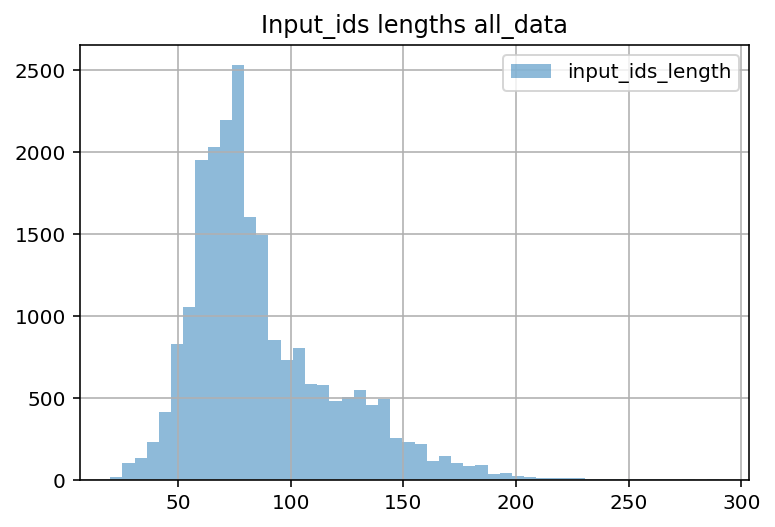

********************************************************************************
Analyzing by label

Describe
         count       mean        std   min   25%   50%    75%    99%    max
label                                                                      
0      11000.0  85.486273  31.250010  21.0  65.0  76.0  100.0  181.0  266.0
1      11000.0  88.750455  32.824624  20.0  66.0  80.0  106.0  186.0  290.0
Histogram


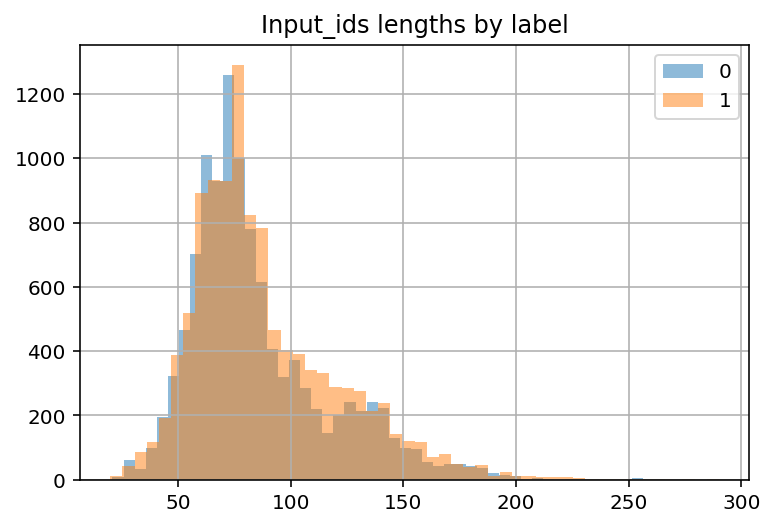

In [ ]:
def check_token_lengths(ds):
    # get data from all partitions
    tokenized_lenghts = (
        pl.from_arrow(datasets.concatenate_datasets(list(ds.values())).data.table)
        .with_columns(pl.col('input_ids').arr.lengths().alias('input_ids_length'))
        .select('input_ids_length', 'label')
        .to_pandas())

    grouped = tokenized_lenghts.groupby('label')
    desc_to_data = {
        'all_data': tokenized_lenghts.input_ids_length,
        'by label': grouped.input_ids_length
    }
    for desc, data in desc_to_data.items():
        print(80 * '*')
        print(f'Analyzing {desc}')
        print('\nDescribe')
        print(data.describe(percentiles=[.25, .5, .75, .99]))

        print('Histogram')
        data.hist(legend=True, bins=50,alpha=0.5)
        plt.title(f'Input_ids lengths {desc}')
        plt.show()     

check_token_lengths(ds_tokens_no_limit)

Documentos relevantes parecem ser um pouco mais longos.

Dadas as análises acima, vamos utilizar um comprimento máximo de 200 tokens (já considerando tokens especiais). 
O jeito mais simples de fazer esse truncamento é refazer o dataset, dessa vez especificando o tamanho máximo usado na tokenização.

In [ ]:
ds_tokens_no_limit['train'].select(range(10))

Dataset({
    features: ['query', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})

In [ ]:
tokenizer('is a little caffeine ok during pregnancy', "We don't know a lot about the effects of caffeine during pregnancy on you and your baby. So it's best to limit the amount you get each day. If you're pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1½ 8-ounce cups of coffee or one 12-ounce cup of coffee.")

{'input_ids': [101, 2003, 1037, 2210, 24689, 7959, 3170, 7929, 2076, 10032, 102, 2057, 2123, 1005, 1056, 2113, 1037, 2843, 2055, 1996, 3896, 1997, 24689, 7959, 3170, 2076, 10032, 2006, 2017, 1998, 2115, 3336, 1012, 2061, 2009, 1005, 1055, 2190, 2000, 5787, 1996, 3815, 2017, 2131, 2169, 2154, 1012, 2065, 2017, 1005, 2128, 6875, 1010, 5787, 24689, 7959, 3170, 2000, 3263, 4971, 8004, 6444, 2015, 2169, 2154, 1012, 2023, 2003, 2055, 1996, 3815, 1999, 1015, 13714, 1022, 1011, 19471, 10268, 1997, 4157, 2030, 2028, 2260, 1011, 19471, 2452, 1997, 4157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Special tokens:

In [ ]:
toolz.valmap(lambda x: (x, tokenizer.vocab[x]), tokenizer.special_tokens_map_extended)

{'unk_token': ('[UNK]', 100),
 'sep_token': ('[SEP]', 102),
 'pad_token': ('[PAD]', 0),
 'cls_token': ('[CLS]', 101),
 'mask_token': ('[MASK]', 103)}

### Final dataset with truncated sentences

In [ ]:
ds_truncate_tokens  = ds_raw.map(
    functools.partial(encode, tokenizer=tokenizer, max_length=200,
                      padding=False, truncation=True,return_length=True),
                      batched=True, num_proc=mp.cpu_count())
ds_truncate_tokens['train'].data.to_pandas().head().T

Map (num_proc=2):   0%|          | 0/19800 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2200 [00:00<?, ? examples/s]

,0,1,2,3,4
query,who founded the new york colony,how many years does it take to become a archit...,what county is sardinia ny in?,where is the nfl hall of fame football?,what county is johnsonville ny in
document,The New York Colony was one of the four Middle...,The Engineer in Training (EIT) certification i...,ERIE.GOV | Your information resource from the ...,Pro Football Hall of Fame. The Pro Football Ha...,"Pelham and Pelham Manor in Westchester County,..."
label,1,0,1,1,0
input_ids,"[101, 2040, 2631, 1996, 2047, 2259, 5701, 102,...","[101, 2129, 2116, 2086, 2515, 2009, 2202, 2000...","[101, 2054, 2221, 2003, 21594, 6396, 1999, 102...","[101, 2073, 2003, 1996, 5088, 2534, 1997, 4476...","[101, 2054, 2221, 2003, 3779, 3077, 6396, 1999..."
token_type_ids,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
length,84,136,80,57,64


********************************************************************************
Analyzing all_data

Describe
count    22000.000000
mean        87.034136
std         31.736989
min         20.000000
25%         66.000000
50%         78.000000
75%        103.000000
99%        183.000000
max        200.000000
Name: input_ids_length, dtype: float64
Histogram


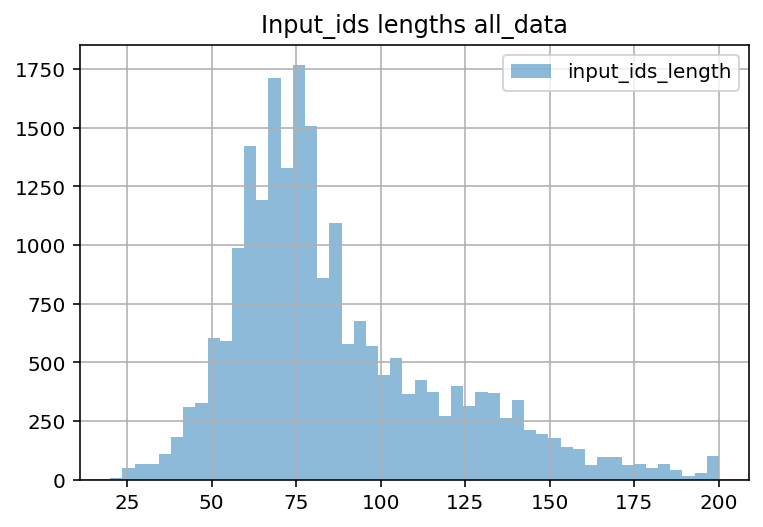

********************************************************************************
Analyzing by label

Describe
         count       mean        std   min   25%   50%    75%    99%    max
label                                                                      
0      11000.0  85.437364  31.035549  21.0  65.0  76.0  100.0  181.0  200.0
1      11000.0  88.630909  32.345934  20.0  66.0  80.0  106.0  186.0  200.0
Histogram


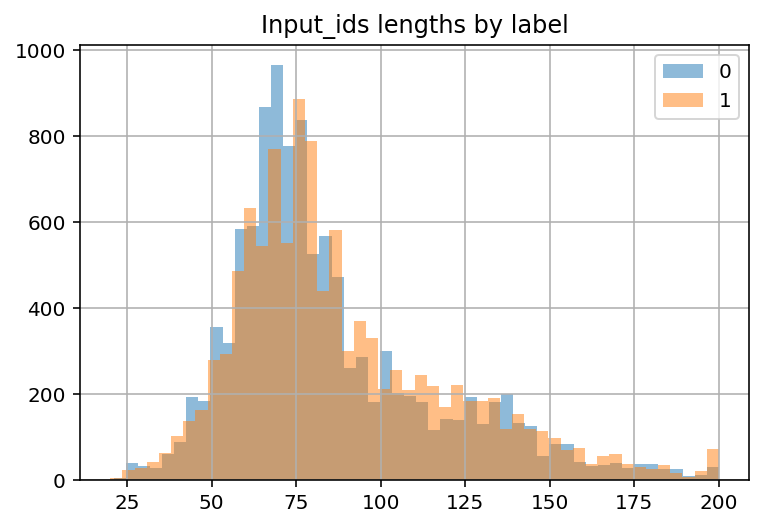

In [ ]:
check_token_lengths(ds_truncate_tokens)

## Model fine tuning

Getting datasets values for easier data manipulation:

In [ ]:
ds_train = ds_truncate_tokens['train']
ds_dev = ds_truncate_tokens['validation']

### Single example overfit

Here we check if we can at least get perfect metrics for a single example.

In [ ]:
from transformers import Trainer, TrainingArguments
os.environ['NEPTUNE_MODE'] = 'debug'

In [ ]:
ds_train_single_example = ds_train.select([1])
ds_train_single_example

Dataset({
    features: ['query', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1
})

In [ ]:
# https://huggingface.co/docs/transformers/training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': (predictions == labels).mean()}

In [ ]:
training_args = TrainingArguments(
    output_dir='./models/single_example_overfit',
    num_train_epochs=20,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=0,
    weight_decay=False,
    adafactor=False,
    lr_scheduler_type='constant',
    learning_rate=5e-5,
    logging_dir='./logs',
    # logging_steps=1,
    evaluation_strategy='epoch',
    # evaluation_strategy='no',
    logging_strategy='epoch',
)

model = AutoModelForSequenceClassification.from_pretrained('nreimers/MiniLM-L6-H384-uncased')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_single_example,
    eval_dataset=ds_train_single_example,
    tokenizer=tokenizer,
    callbacks=[transformers.DefaultFlowCallback],
    compute_metrics=compute_metrics
)
# trainer.callback_handler.callbacks.clear()
# trainer.callback_handler.add_callback(transformers.DefaultFlowCallback)
# trainer.callback_handler.add_callback(transformers.PrinterCallback)
# trainer.callback_handler.add_callback(transformers.ProgressCallback)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/usr/local/lib/python3.9/dist-packages/transformers/integrations.py:1114: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune.new.metadata_containers.run import Run
You are adding 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.709700,0.687646,1.000000
2,0.687600,0.659248,1.000000
3,0.651700,0.628564,1.000000
4,0.629700,0.595154,1.000000
5,0.578600,0.560012,1.000000
6,0.567300,0.520584,1.000000
7,0.511700,0.479349,1.000000
8,0.455800,0.434273,1.000000
9,0.444900,0.388708,1.000000
10,0.397700,0.344371,1.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *

Shutting down background jobs, please wait a moment...
Done!


TrainOutput(global_step=20, training_loss=0.3880466617643833, metrics={'train_runtime': 3.9753, 'train_samples_per_second': 5.031, 'train_steps_per_second': 5.031, 'total_flos': 259107888000.0, 'train_loss': 0.3880466617643833, 'epoch': 20.0})

In [ ]:
del model, training_args, trainer

Conclusion: we can overfit a single example

### One batch ovefit

In [ ]:
ds_train_single_batch = ds_train.select(range(8))
ds_train_single_batch

Dataset({
    features: ['query', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8
})

In [ ]:
training_args = TrainingArguments(
    output_dir='./models/single_batch_overfit',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=0,
    weight_decay=False,
    adafactor=False,
    lr_scheduler_type='constant',
    learning_rate=5e-5,
    logging_dir='./logs',
    # logging_steps=1,
    evaluation_strategy='epoch',
    # evaluation_strategy='no',
    logging_strategy='epoch',
)

model = AutoModelForSequenceClassification.from_pretrained('nreimers/MiniLM-L6-H384-uncased')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_single_batch,
    eval_dataset=ds_train_single_batch,
    tokenizer=tokenizer,
    callbacks=[transformers.DefaultFlowCallback],
    compute_metrics=compute_metrics
)

trainer.train()
del model, training_args, trainer

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nreimers--MiniLM-L6-H384-uncased/snapshots/3276f0fac9d818781d7a1327b3ff818fc4e643c0/config.json
Model config BertConfig {
  "_name_or_path": "nreimers/MiniLM-L6-H384-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.688900,0.692616,0.500000
2,0.690700,0.690157,0.500000
3,0.685500,0.687217,0.500000
4,0.694100,0.683876,0.500000
5,0.684800,0.680475,0.875000
6,0.679100,0.677537,1.000000
7,0.678300,0.670831,1.000000
8,0.677700,0.658192,1.000000
9,0.660500,0.644809,1.000000
10,0.655200,0.631408,1.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, query. If document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *

Shutting down background jobs, please wait a moment...
Done!


Conclusion: we can overfit a single batch.

### Finetuning

In [ ]:
training_args = TrainingArguments(
    output_dir='./models/finetuned_minilm',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=0,
    weight_decay=False,
    adafactor=False,
    lr_scheduler_type='constant',
    learning_rate=5e-5,
    logging_dir='./logs',
    # logging_steps=1,
    evaluation_strategy='epoch',
    # evaluation_strategy='no',
    logging_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    seed=12345,
    data_seed=12345,
    save_total_limit=1,
    group_by_length=True,
    length_column_name=True
)

model = AutoModelForSequenceClassification.from_pretrained(
    'nreimers/MiniLM-L6-H384-uncased')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nreimers--MiniLM-L6-H384-uncased/snapshots/3276f0fac9d818781d7a1327b3ff818fc4e643c0/config.json
Model config BertConfig {
  "_name_or_path": "nreimers/MiniLM-L6-H384-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: length, document, query. If length, document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 19800
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12380
  Number of trainable parameters = 22713986


Epoch,Training Loss,Validation Loss,Accuracy
1,0.537100,0.294124,0.878182
2,0.276300,0.259004,0.898636
3,0.189900,0.308098,0.895909
4,0.125700,0.257628,0.917727
5,0.092900,0.394939,0.905909
6,0.080600,0.330439,0.917273
7,0.062900,0.421384,0.907273
8,0.047400,0.462463,0.914545
9,0.049800,0.422735,0.923636
10,0.049000,0.554873,0.894545


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: length, document, query. If length, document, query are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2200
  Batch size = 32
Saving model checkpoint to ./models/finetuned_minilm/checkpoint-619
Configuration saved in ./models/finetuned_minilm/checkpoint-619/config.json
Model weights saved in ./models/finetuned_minilm/checkpoint-619/pytorch_model.bin
tokenizer config file saved in ./models/finetuned_minilm/checkpoint-619/tokenizer_config.json
Special tokens file saved in ./models/finetuned_minilm/checkpoint-619/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: length, document, query. If length, document, query are not expected by `

Shutting down background jobs, please wait a moment...
Done!


TrainOutput(global_step=12380, training_loss=0.08814392397977616, metrics={'train_runtime': 1311.5964, 'train_samples_per_second': 301.922, 'train_steps_per_second': 9.439, 'total_flos': 2278044421917888.0, 'train_loss': 0.08814392397977616, 'epoch': 20.0})

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

In [ ]:
model.push_to_hub('MiniLM-L6-H384-uncased-msmarco-tiny-finetune')
tokenizer.push_to_hub('MiniLM-L6-H384-uncased-msmarco-tiny-finetune')
trainer.push_to_hub('MiniLM-L6-H384-uncased-msmarco-tiny-finetune')

Configuration saved in /tmp/tmpp4373zpe/config.json
Model weights saved in /tmp/tmpp4373zpe/pytorch_model.bin
Uploading the following files to marcospiau/MiniLM-L6-H384-uncased-msmarco-tiny-finetune: config.json,pytorch_model.bin
tokenizer config file saved in /tmp/tmp3tfc25qr/tokenizer_config.json
Special tokens file saved in /tmp/tmp3tfc25qr/special_tokens_map.json
Uploading the following files to marcospiau/MiniLM-L6-H384-uncased-msmarco-tiny-finetune: tokenizer_config.json,vocab.txt,tokenizer.json,special_tokens_map.json
Cloning https://huggingface.co/marcospiau/finetuned_minilm into local empty directory.
Saving model checkpoint to ./models/finetuned_minilm
Configuration saved in ./models/finetuned_minilm/config.json
Model weights saved in ./models/finetuned_minilm/pytorch_model.bin
tokenizer config file saved in ./models/finetuned_minilm/tokenizer_config.json
Special tokens file saved in ./models/finetuned_minilm/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/86.7M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/marcospiau/finetuned_minilm
   d4f59e9..5ba3ccb  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/marcospiau/finetuned_minilm
   d4f59e9..5ba3ccb  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9022727272727272}]}
To https://huggingface.co/marcospiau/finetuned_minilm
   5ba3ccb..e39072e  main -> main

   5ba3ccb..e39072e  main -> main



'https://huggingface.co/marcospiau/finetuned_minilm/commit/5ba3ccb00d49b3dc75ba7a4811d1cdefdc41fecc'

We have an initial version of a finetuned model uploaded to HuggingFace ModelHUb on https://huggingface.co/marcospiau/MiniLM-L6-H384-uncased-msmarco-tiny-finetune